In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import shap

from torch import nn
from torch_geometric.nn import MLP
from torch.optim import Adam
from torch.nn.functional import cross_entropy

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns

from torch_geometric.nn.aggr.deep_sets import DeepSetsAggregation


from itertools import product 


In [2]:
train = pd.read_csv('csv_files_harmonized/train.csv') # balanced?
test = pd.read_csv('csv_files_harmonized/test.csv')
val = pd.read_csv('csv_files_harmonized/val.csv')

In [4]:
marker_columns = [col for col in train.columns if col.startswith('CD') or col.startswith('HLA-DR')]
marker_columns

['CD16',
 'CD4',
 'CD14',
 'CD19',
 'CD3',
 'CD235ab',
 'CD11c',
 'CD33',
 'CD133',
 'CD123',
 'CD162',
 'CD185',
 'CD45RA',
 'CD278',
 'CD194',
 'CD161',
 'CD184',
 'CD27',
 'CD44',
 'CD127',
 'CD10',
 'CD73',
 'HLA-DR',
 'CD146',
 'CD117',
 'CD8a',
 'CD34',
 'CD105',
 'CD49d',
 'CD20',
 'CD25',
 'CD66b',
 'CD49f',
 'CD45RO',
 'CD90',
 'CD45',
 'CD195',
 'CD38',
 'CD196',
 'CD135',
 'CD56']

In [5]:
train[marker_columns] = np.arcsinh(train[marker_columns]/5)
test[marker_columns] = np.arcsinh(test[marker_columns]/5)
val[marker_columns] = np.arcsinh(val[marker_columns]/5)

In [6]:
train['group'] = train['group'].map({'baseline': 0, 'post': 1, 'healthy': 2})
test['group'] = test['group'].map({'baseline': 0, 'post': 1, 'healthy': 2})
val['group'] = val['group'].map({'baseline': 0, 'post': 1, 'healthy': 2})

In [7]:
for i in [train, test, val]:
    i['id_split'] = i['id']
    i.loc[i['group'] == 1, 'id_split'] = i.loc[i['group'] == 1, 'id'] + '_post'

In [8]:
train['id_numeric'], train_id_mapping = pd.factorize(train['id_split'])
test['id_numeric'], test_id_mapping = pd.factorize(test['id_split'])
val['id_numeric'], val_id_mapping = pd.factorize(val['id_split'])

In [9]:
features = torch.tensor(train[marker_columns].values, dtype=torch.float)
labels = torch.tensor(train['group'].values, dtype=torch.long)
id_splits = torch.tensor(train['id_numeric'].values, dtype=torch.long)

In [10]:
unique_id_splits = torch.unique(id_splits)
id_to_batch = {id_val.item(): i for i, id_val in enumerate(unique_id_splits)}
batch_indices = torch.tensor([id_to_batch[id_val.item()] for id_val in id_splits], dtype=torch.long)

val_unique_id_splits = torch.tensor(val['id_numeric'].unique(), dtype=torch.long)

In [11]:
def initialize_model(features, local_hidden_sizes, global_hidden_sizes, dropout):
    local_mlp = MLP([features.shape[1]] + local_hidden_sizes, dropout=dropout)
    global_hidden_sizes = [local_hidden_sizes[-1]] + global_hidden_sizes + [3]
    global_mlp = MLP(global_hidden_sizes, dropout=dropout)
    
    return DeepSetsAggregation(local_mlp, global_mlp)

In [12]:
def evaluate_loss(aggregation, features, index, labels, id_splits, val_unique_id_splits):
    aggregation.eval()
    with torch.no_grad():
        batch_predictions = aggregation(features, index=index)

        batch_predictions = batch_predictions[val_unique_id_splits]

        batch_labels = torch.tensor(
            [labels[id_splits == id_val].mode().values.item() for id_val in val_unique_id_splits],
            dtype=torch.long
        )

        loss = cross_entropy(batch_predictions, batch_labels)

    return loss.item()

In [13]:
def evaluate_patient_accuracy(aggregation, features, index, labels, id_splits, val_unique_id_splits):
    aggregation.eval()
    with torch.no_grad():
        batch_predictions = aggregation(features, index=index)

        batch_predictions = batch_predictions[val_unique_id_splits]

        predicted_classes = batch_predictions.argmax(dim=1)

        batch_labels = torch.tensor(
            [labels[id_splits == id_val].mode().values.item() for id_val in val_unique_id_splits],
            dtype=torch.long
        )

        correct_preds = (predicted_classes == batch_labels).sum().item()
        accuracy = correct_preds / len(val_unique_id_splits)  

    return accuracy


In [14]:
def train_model(local_hidden_sizes, global_hidden_sizes, dropout, lr, epochs, print_epoch=False):
    deepsetaggregation = initialize_model(features, local_hidden_sizes, global_hidden_sizes, dropout)
    optimizer = Adam(deepsetaggregation.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        deepsetaggregation.train()
        optimizer.zero_grad()
        batch_predictions = deepsetaggregation(features, index=batch_indices)

        batch_labels = torch.tensor(
            [labels[id_splits == id_val].mode().values.item() for id_val in unique_id_splits],
            dtype=torch.long
        )

        train_loss = cross_entropy(batch_predictions, batch_labels)
        train_loss.backward()
        optimizer.step()

        val_loss = evaluate_loss(deepsetaggregation, features, batch_indices, labels, id_splits, val_unique_id_splits)
        val_patient_accuracy = evaluate_patient_accuracy(deepsetaggregation, features, batch_indices, labels, id_splits, val_unique_id_splits)

        train_losses.append(train_loss.item())
        val_losses.append(val_loss)

        if print_epoch:
            print(f'Epoch: {epoch}, Train Loss: {train_loss.item()}, Val Loss: {val_loss}, Val accuracy per patient: {val_patient_accuracy}')

    return train_losses, val_losses, val_patient_accuracy, deepsetaggregation

In [15]:
learning_rates = [0.01, 0.001] 
local_hidden_layer_sizes = [
    [64, 32],
    [128, 64, 32]               
]
global_hidden_layer_sizes = [
    [16],       
    [8],          
]
dropout_rates = [0.0, 0.1, 0.5]
epochs_list = [10]
results = []

combination: LR=0.01, Local hidden layers=[64, 32], Global hidden layers [32, 16], Dropout=0.0, Epochs=10
Final val accuracy: 0.7777777777777778


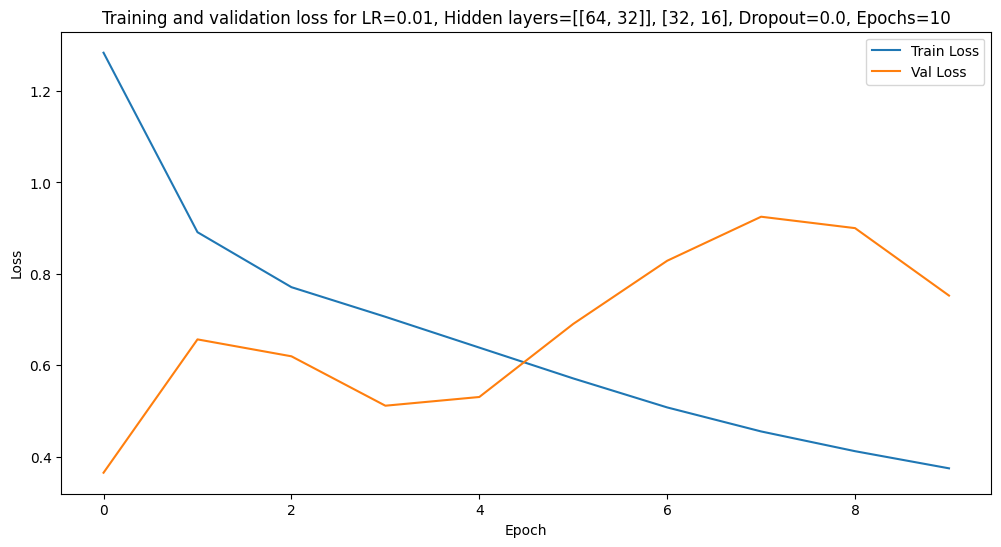

combination: LR=0.01, Local hidden layers=[64, 32], Global hidden layers [32, 16], Dropout=0.1, Epochs=10
Final val accuracy: 0.8888888888888888


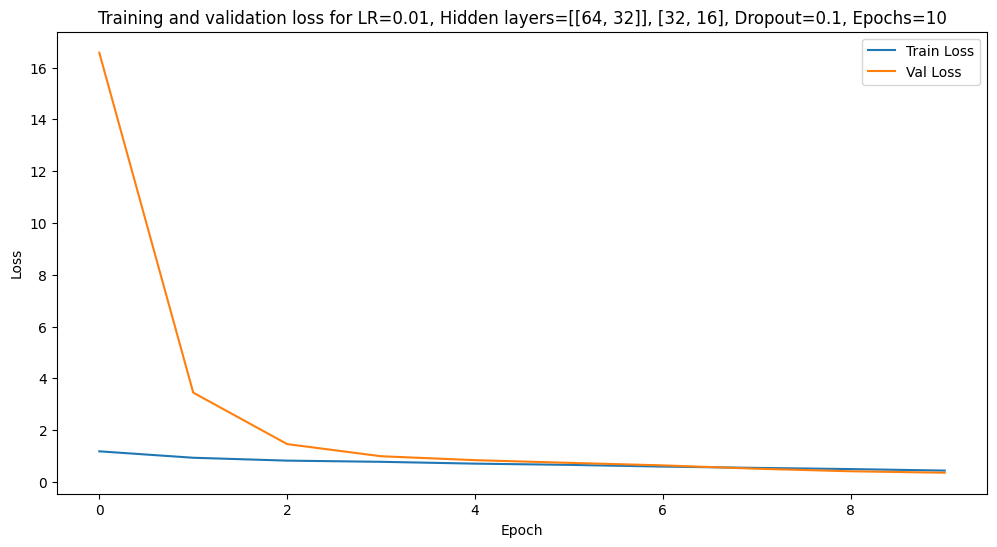

combination: LR=0.01, Local hidden layers=[64, 32], Global hidden layers [32, 16], Dropout=0.5, Epochs=10
Final val accuracy: 0.8888888888888888


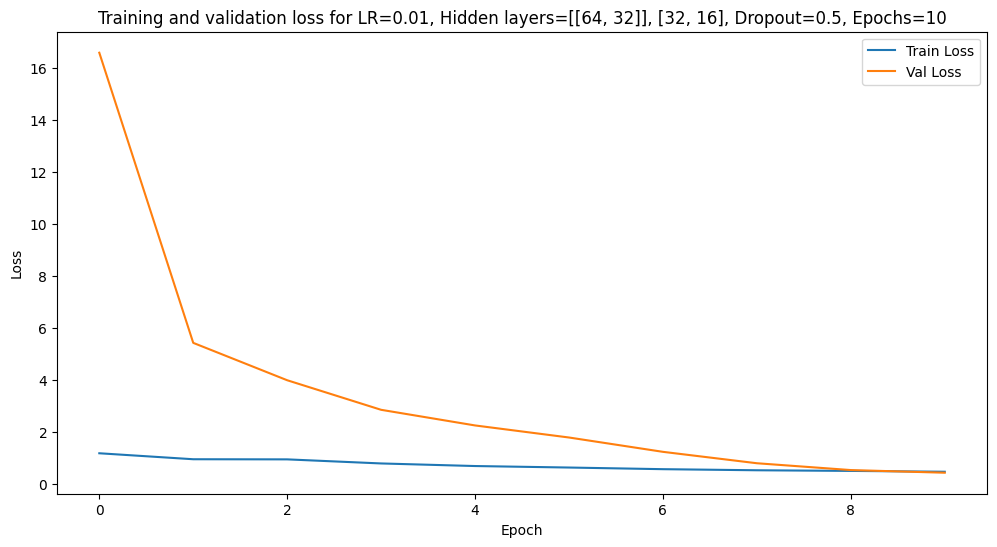

combination: LR=0.01, Local hidden layers=[64, 32], Global hidden layers [32, 8], Dropout=0.0, Epochs=10
Final val accuracy: 1.0


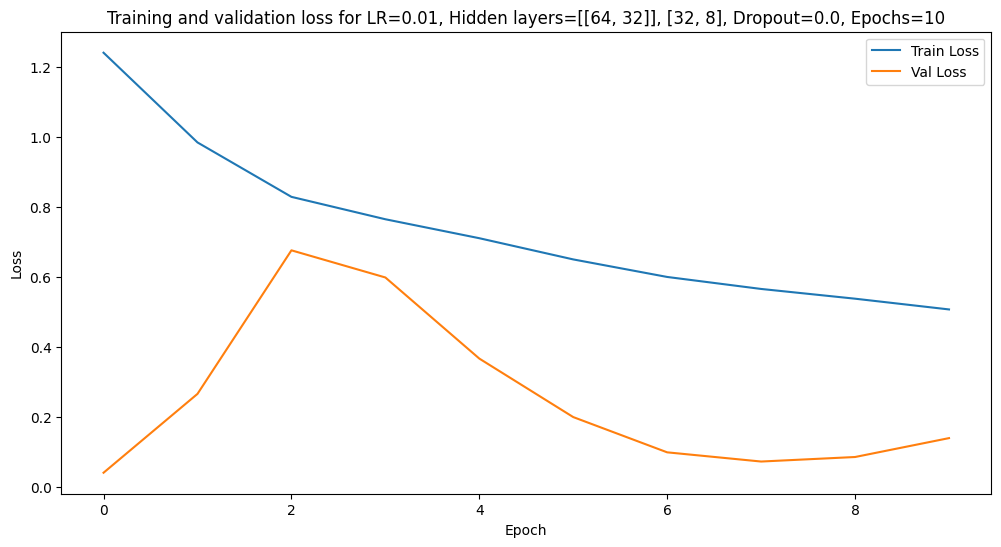

combination: LR=0.01, Local hidden layers=[64, 32], Global hidden layers [32, 8], Dropout=0.1, Epochs=10
Final val accuracy: 1.0


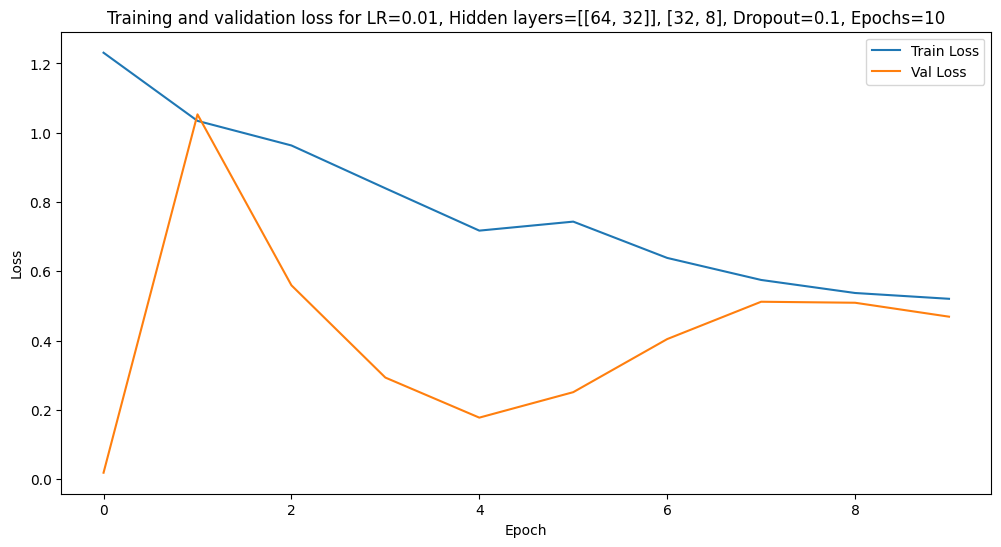

combination: LR=0.01, Local hidden layers=[64, 32], Global hidden layers [32, 8], Dropout=0.5, Epochs=10
Final val accuracy: 0.1111111111111111


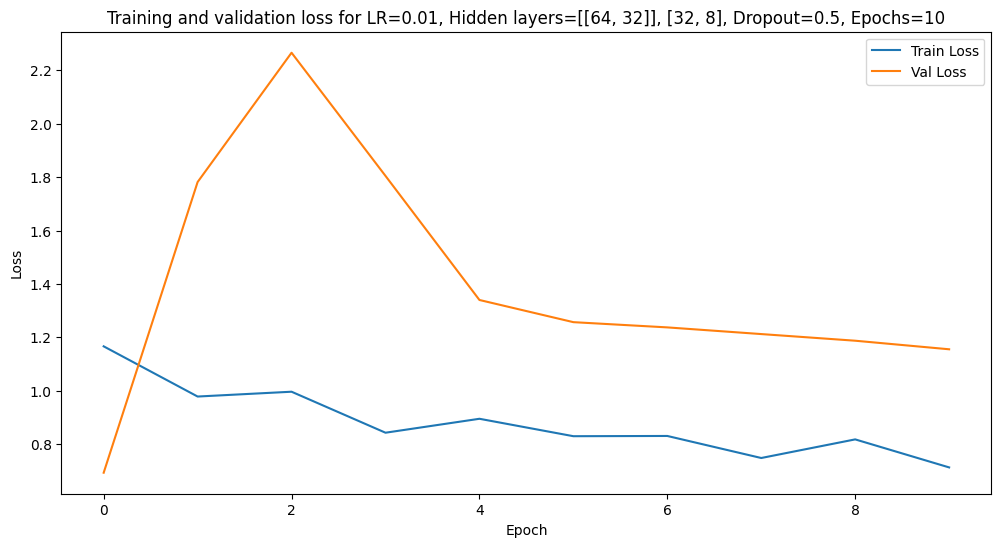

combination: LR=0.01, Local hidden layers=[128, 64, 32], Global hidden layers [32, 16], Dropout=0.0, Epochs=10
Final val accuracy: 0.7777777777777778


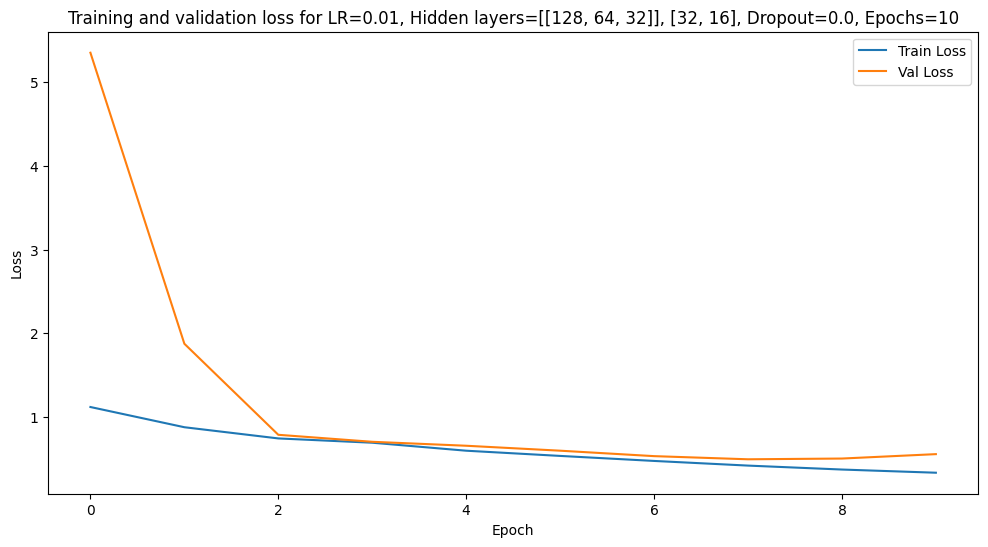

combination: LR=0.01, Local hidden layers=[128, 64, 32], Global hidden layers [32, 16], Dropout=0.1, Epochs=10
Final val accuracy: 0.6666666666666666


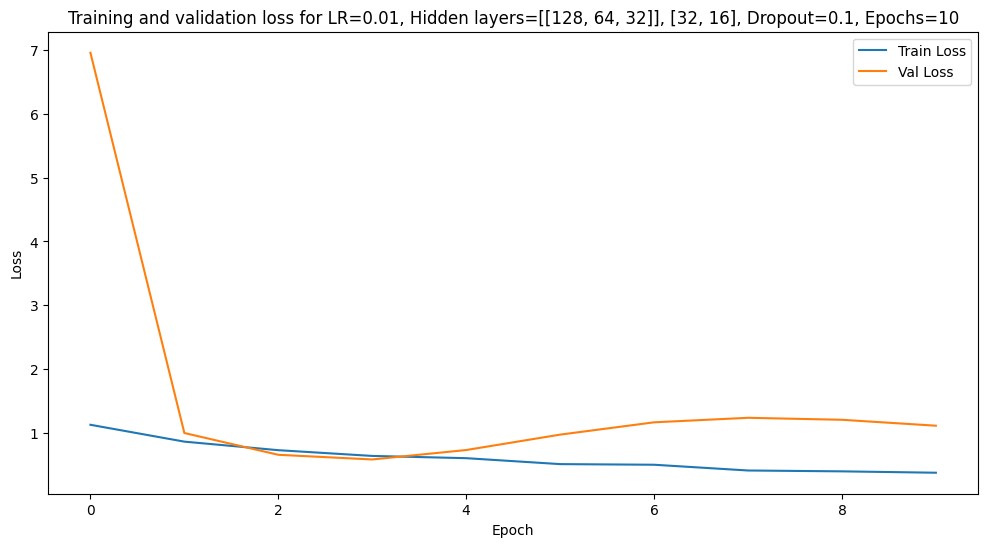

combination: LR=0.01, Local hidden layers=[128, 64, 32], Global hidden layers [32, 16], Dropout=0.5, Epochs=10
Final val accuracy: 1.0


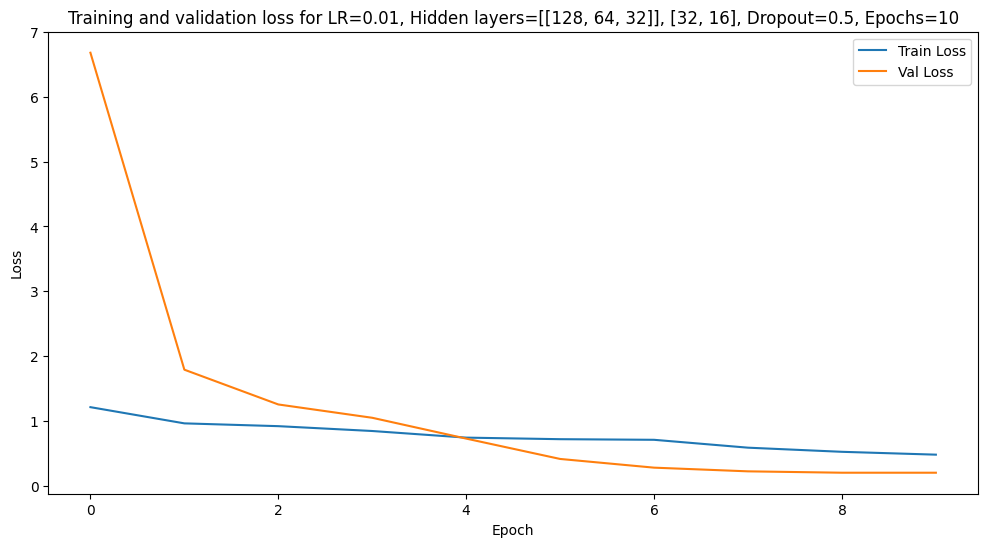

combination: LR=0.01, Local hidden layers=[128, 64, 32], Global hidden layers [32, 8], Dropout=0.0, Epochs=10
Final val accuracy: 1.0


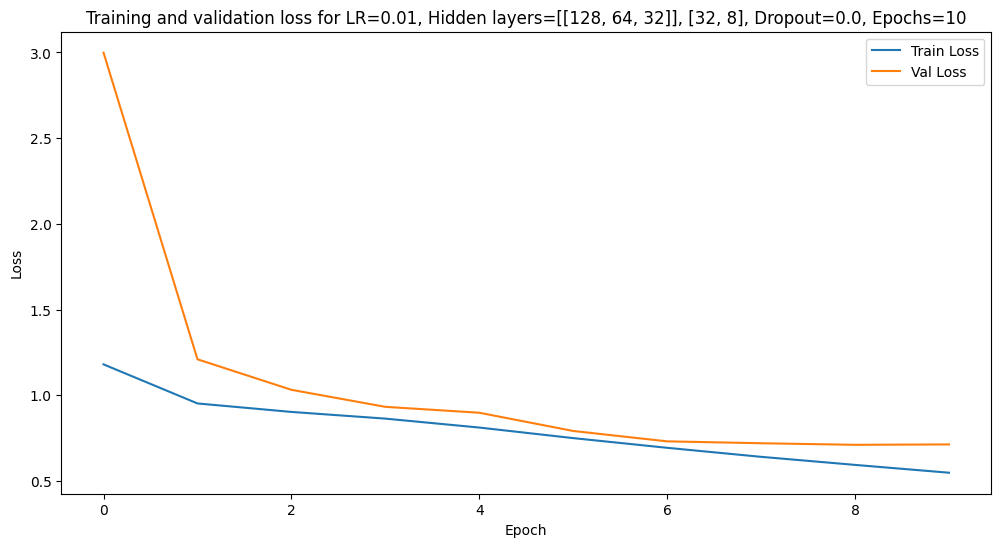

combination: LR=0.01, Local hidden layers=[128, 64, 32], Global hidden layers [32, 8], Dropout=0.1, Epochs=10
Final val accuracy: 0.3333333333333333


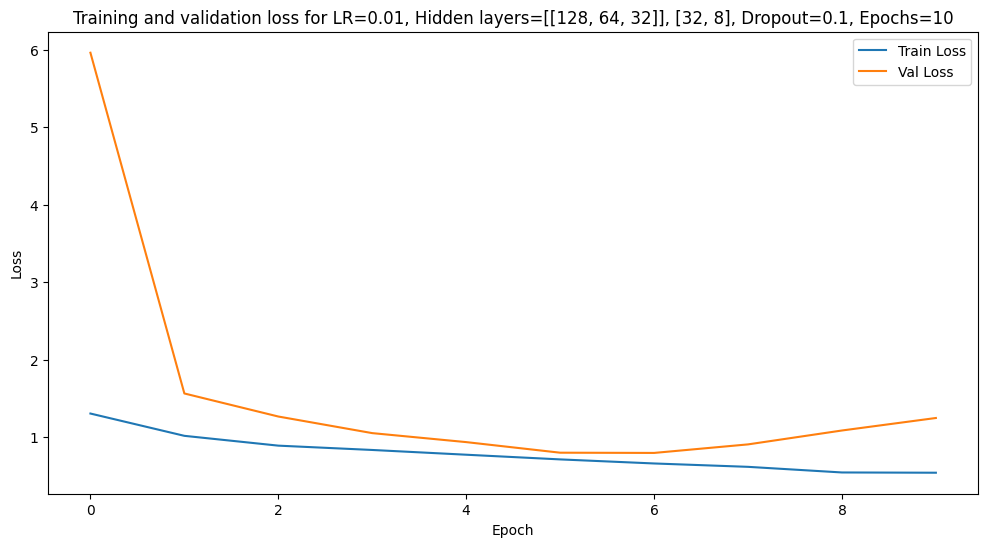

combination: LR=0.01, Local hidden layers=[128, 64, 32], Global hidden layers [32, 8], Dropout=0.5, Epochs=10
Final val accuracy: 0.0


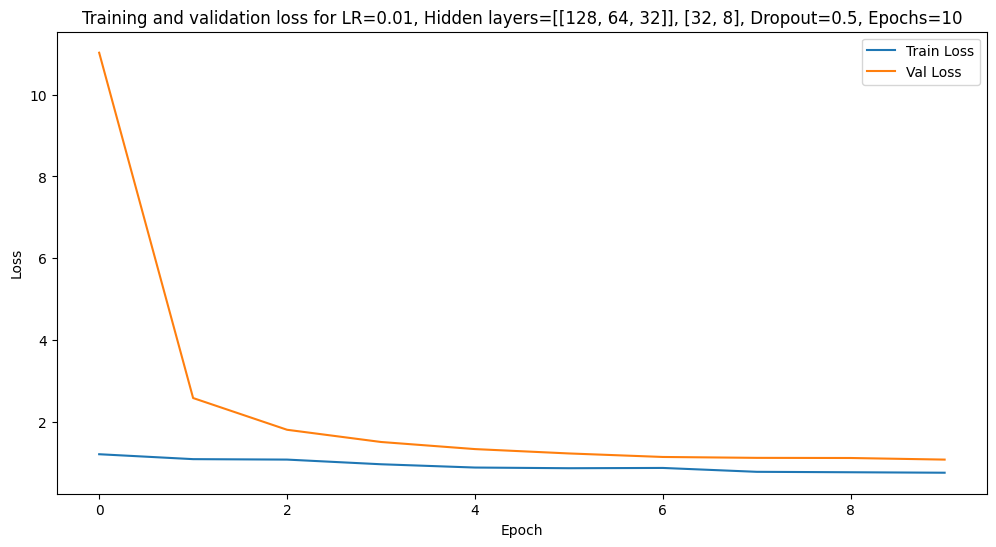

combination: LR=0.001, Local hidden layers=[64, 32], Global hidden layers [32, 16], Dropout=0.0, Epochs=10
Final val accuracy: 1.0


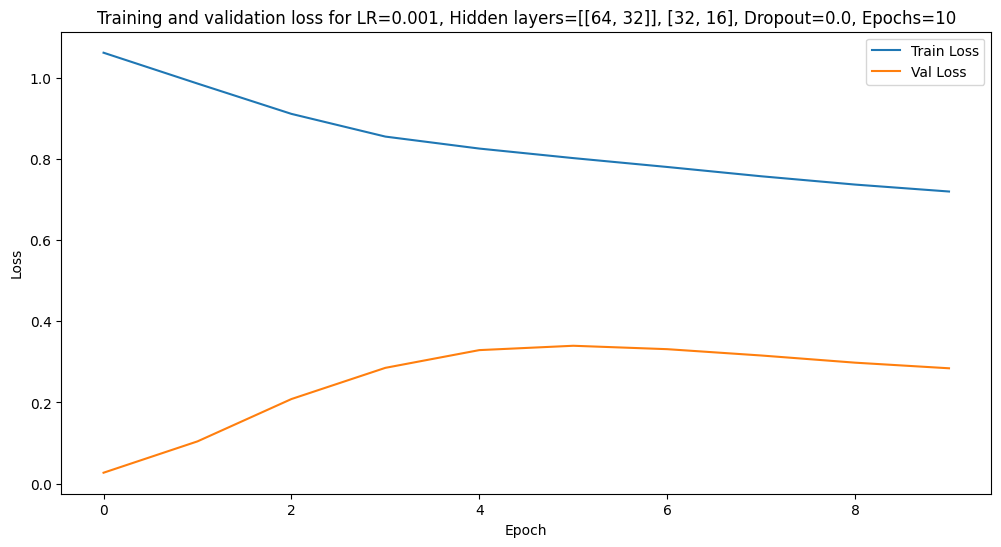

combination: LR=0.001, Local hidden layers=[64, 32], Global hidden layers [32, 16], Dropout=0.1, Epochs=10
Final val accuracy: 0.7777777777777778


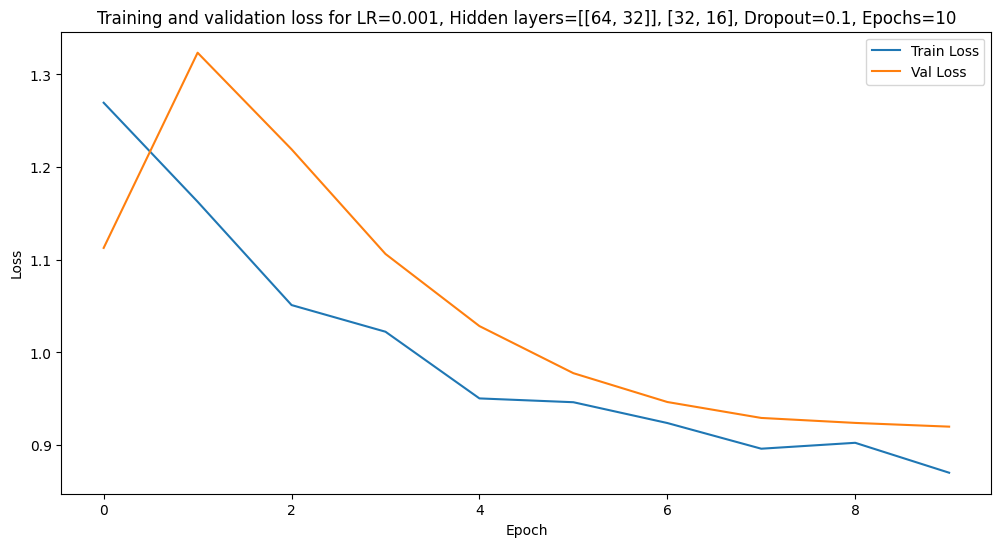

combination: LR=0.001, Local hidden layers=[64, 32], Global hidden layers [32, 16], Dropout=0.5, Epochs=10
Final val accuracy: 0.8888888888888888


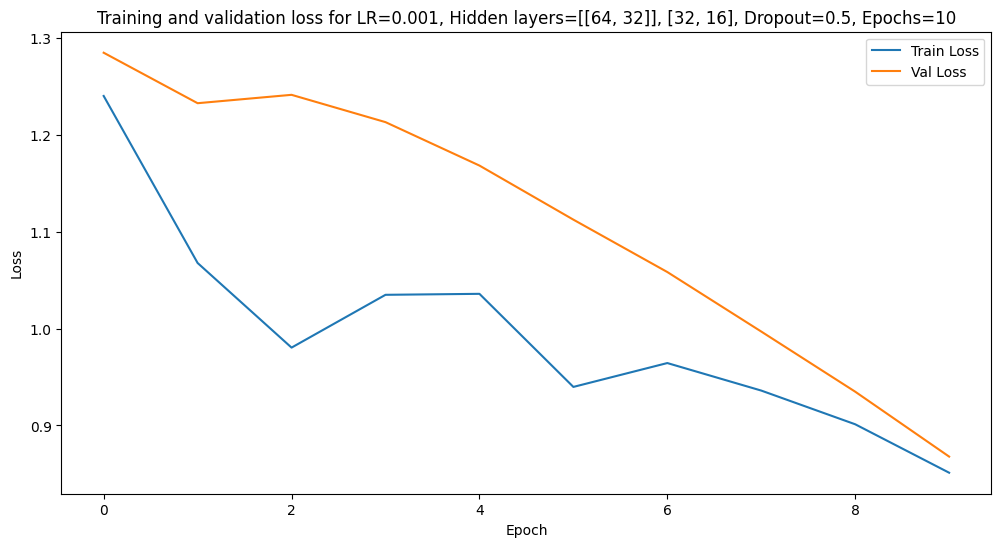

combination: LR=0.001, Local hidden layers=[64, 32], Global hidden layers [32, 8], Dropout=0.0, Epochs=10
Final val accuracy: 0.1111111111111111


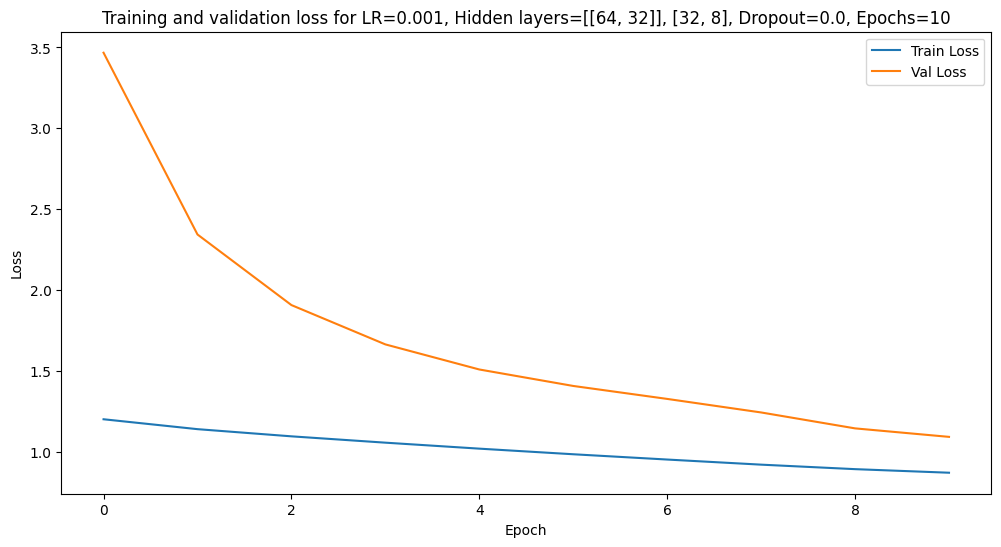

combination: LR=0.001, Local hidden layers=[64, 32], Global hidden layers [32, 8], Dropout=0.1, Epochs=10
Final val accuracy: 0.0


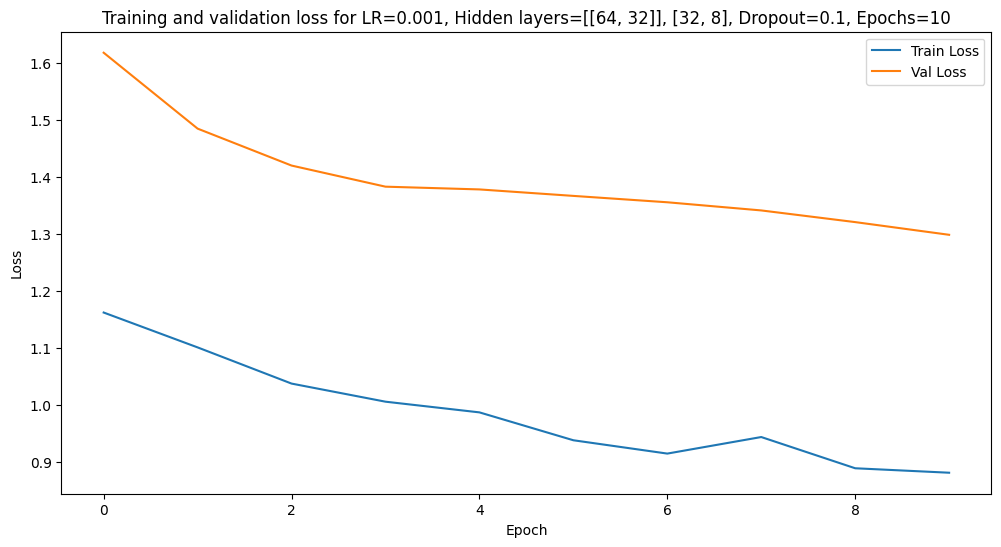

combination: LR=0.001, Local hidden layers=[64, 32], Global hidden layers [32, 8], Dropout=0.5, Epochs=10
Final val accuracy: 1.0


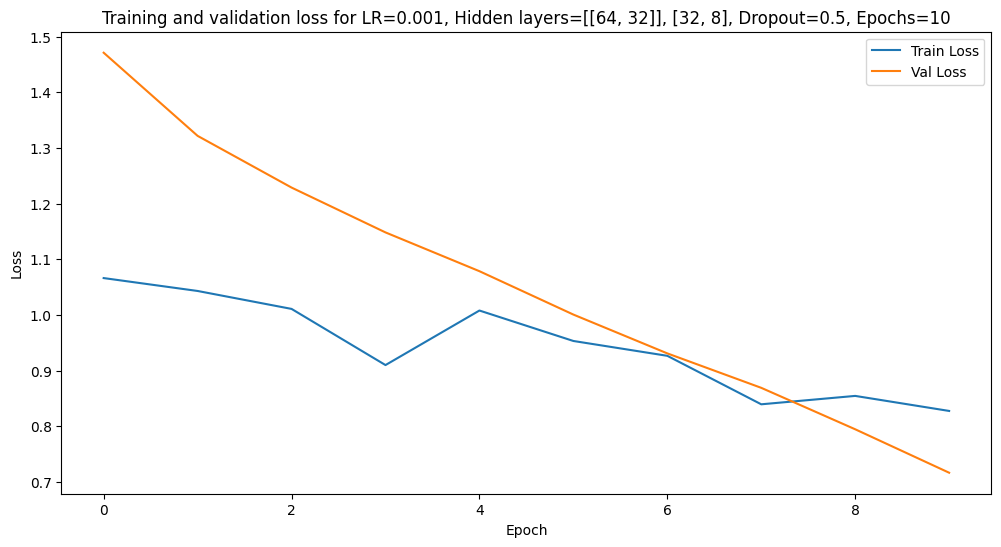

combination: LR=0.001, Local hidden layers=[128, 64, 32], Global hidden layers [32, 16], Dropout=0.0, Epochs=10
Final val accuracy: 1.0


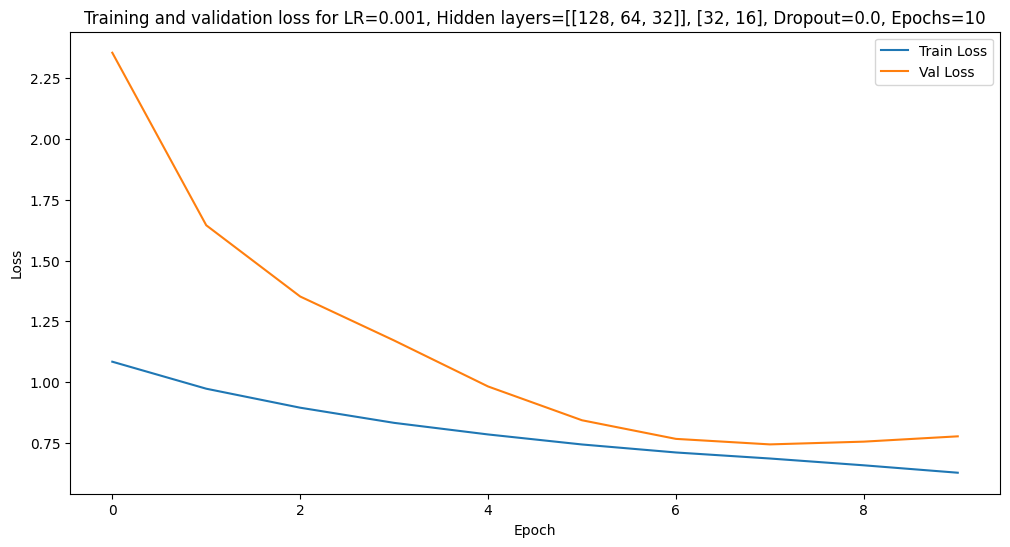

combination: LR=0.001, Local hidden layers=[128, 64, 32], Global hidden layers [32, 16], Dropout=0.1, Epochs=10
Final val accuracy: 1.0


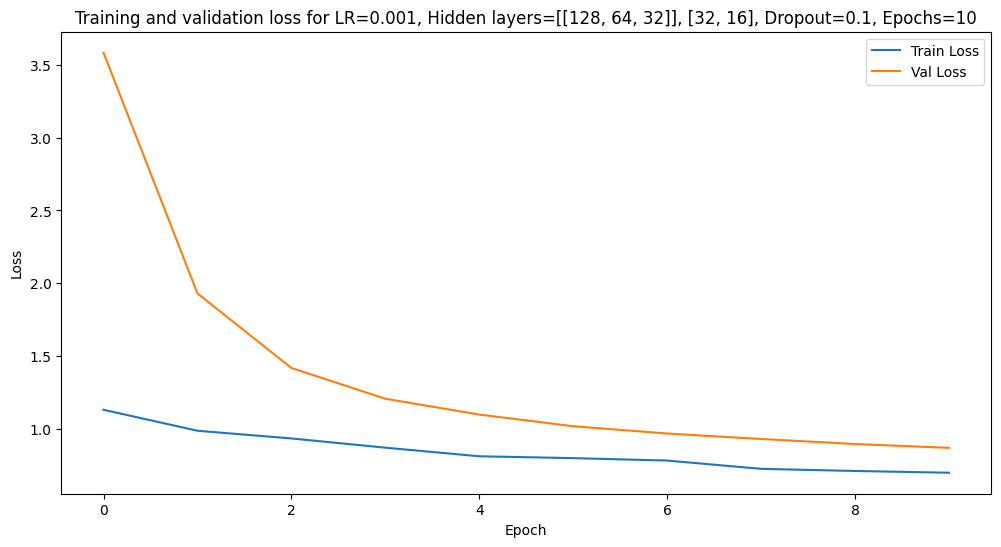

combination: LR=0.001, Local hidden layers=[128, 64, 32], Global hidden layers [32, 16], Dropout=0.5, Epochs=10
Final val accuracy: 1.0


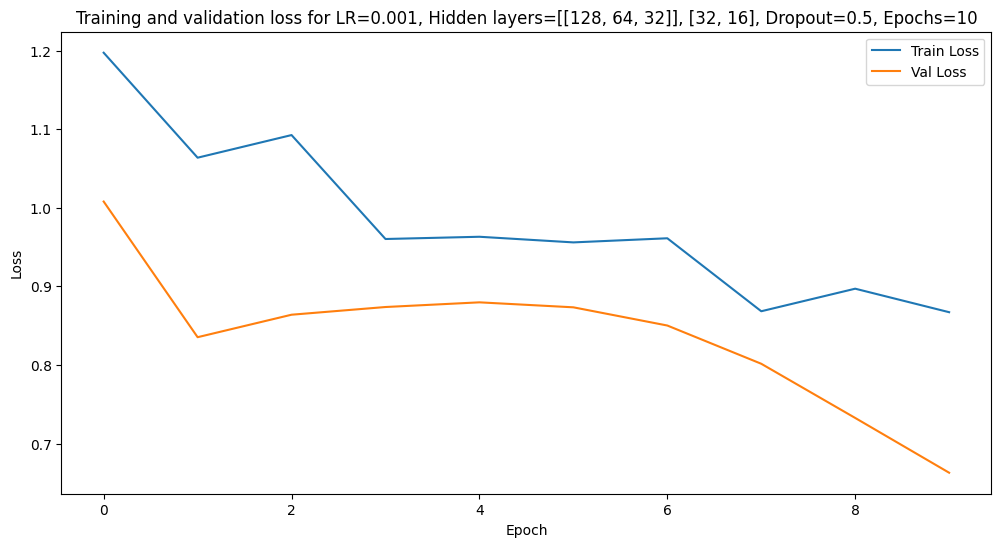

combination: LR=0.001, Local hidden layers=[128, 64, 32], Global hidden layers [32, 8], Dropout=0.0, Epochs=10
Final val accuracy: 0.0


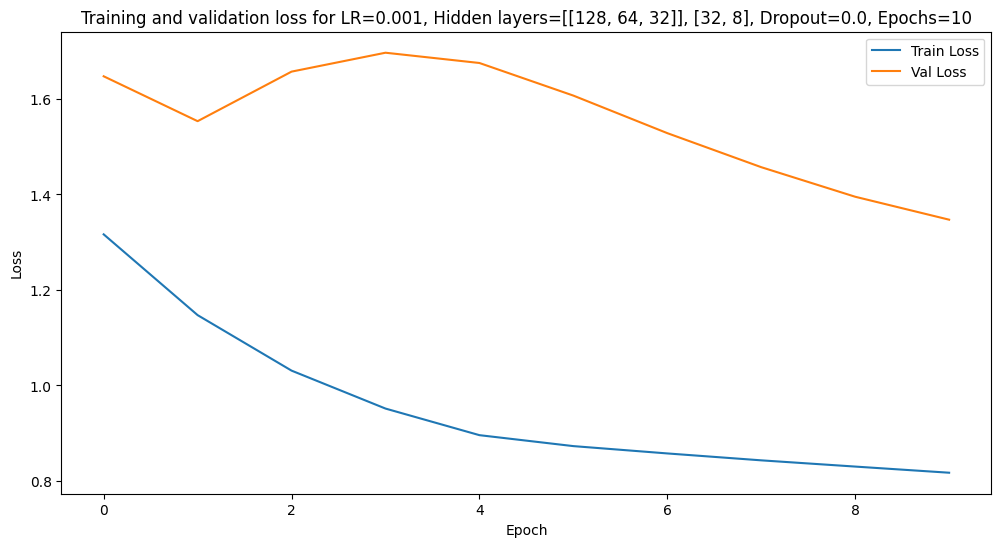

combination: LR=0.001, Local hidden layers=[128, 64, 32], Global hidden layers [32, 8], Dropout=0.1, Epochs=10
Final val accuracy: 1.0


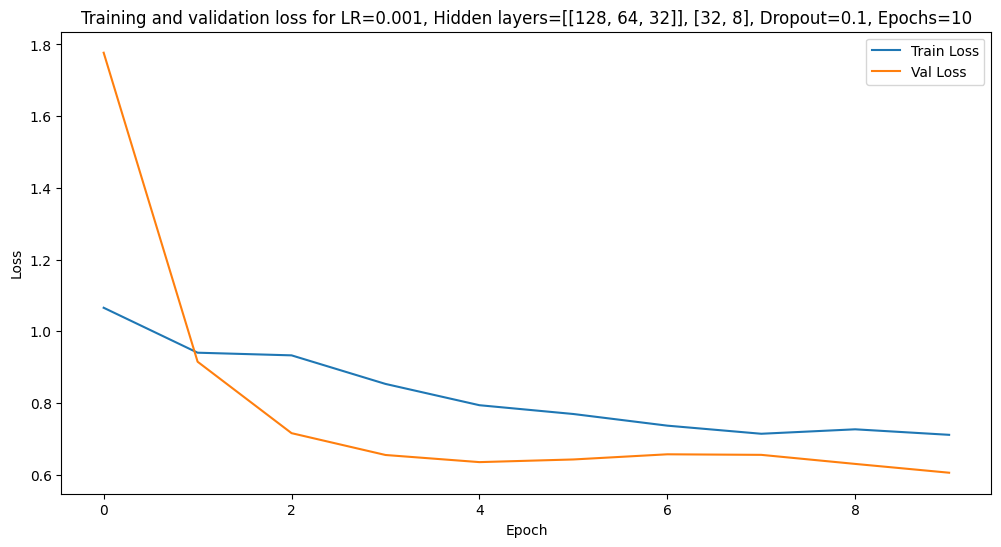

combination: LR=0.001, Local hidden layers=[128, 64, 32], Global hidden layers [32, 8], Dropout=0.5, Epochs=10
Final val accuracy: 0.0


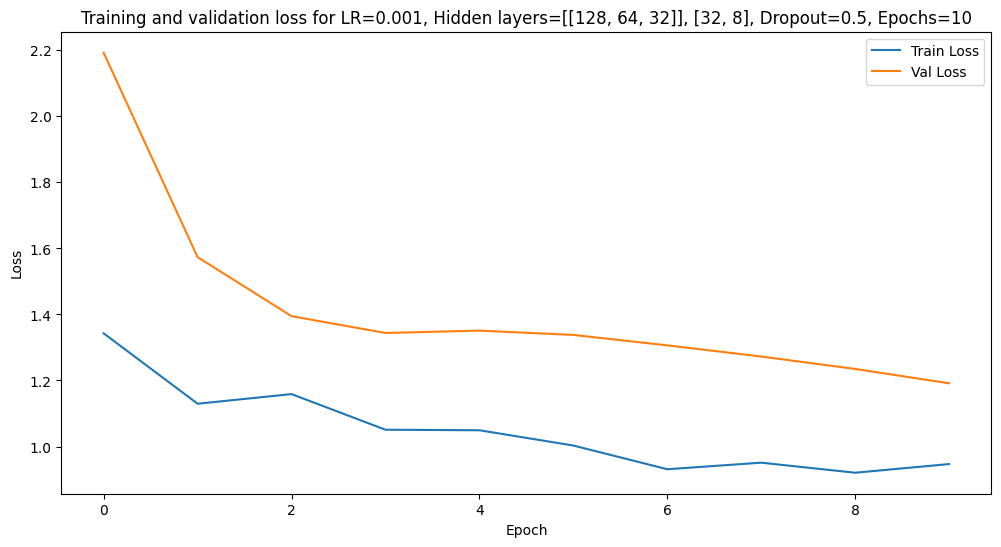

In [16]:
for lr, local_hidden_size, global_hidden_size, dropout, epochs in product(learning_rates, local_hidden_layer_sizes, global_hidden_layer_sizes, dropout_rates, epochs_list): # grid search and saving all models and results
    print(f'combination: LR={lr}, Local hidden layers={local_hidden_size}, Global hidden layers {[local_hidden_size[-1]] + global_hidden_size}, Dropout={dropout}, Epochs={epochs}')
    train_losses, val_losses, val_patient_accuracy, aggregation, = train_model(local_hidden_size, global_hidden_size, dropout, lr, epochs)
    results.append((lr, local_hidden_size,global_hidden_size, dropout, epochs, val_patient_accuracy))

    print(f'Final val accuracy: {val_patient_accuracy}')

    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Training and validation loss for LR={lr}, Hidden layers=[{local_hidden_size}], {[local_hidden_size[-1]] + global_hidden_size}, Dropout={dropout}, Epochs={epochs}')
    plt.show()

In [18]:
best_models = [m for m in results if m[-1] == 1.0]
best_models

[(0.01, [64, 32], [8], 0.0, 10, 1.0),
 (0.01, [64, 32], [8], 0.1, 10, 1.0),
 (0.01, [128, 64, 32], [16], 0.5, 10, 1.0),
 (0.01, [128, 64, 32], [8], 0.0, 10, 1.0),
 (0.001, [64, 32], [16], 0.0, 10, 1.0),
 (0.001, [64, 32], [8], 0.5, 10, 1.0),
 (0.001, [128, 64, 32], [16], 0.0, 10, 1.0),
 (0.001, [128, 64, 32], [16], 0.1, 10, 1.0),
 (0.001, [128, 64, 32], [16], 0.5, 10, 1.0),
 (0.001, [128, 64, 32], [8], 0.1, 10, 1.0)]